# Face Recognition

<h3>Import Libraries</h3>

In [1]:
import sys
import time
import numpy as np
from scipy.io import loadmat
from scipy.stats import mode

%matplotlib inline
import matplotlib.pyplot as plt

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.8.9


Previously made functions from other notebook

In [2]:
def innerproduct(X, Z=None):
    """
    This function computes the inner-product matrix.
    
    Syntax:
    ------
    D = innerproduct(X,Z)
    
    Inputs:
    ------
    X : nxd data matrix with n vectors (rows) of dimensionality d
    Z : mxd data matrix with m vectors (rows) of dimensionality d
    
    Outputs:
    -------
    Matrix G of size nxm
    G[i,j] is the inner-product between vectors X[i,:] and Z[j,:]
    
    This function can be called with only one input:
    innerproduct(X) = innerproduct(X,X)
    """
    if Z is None:
        Z = X
    res = np.dot(X, Z.T)
    
    return res

In [3]:
def l2distance(X, Z=None):
    """
    function D=l2distance(X,Z)
    
    This function computes the Euclidean distance matrix.
    
    Syntax:
    ------
    D = l2distance(X,Z)
    
    Inputs:
    ------
    X : nxd data matrix with n vectors (rows) of dimensionality d
    Z : mxd data matrix with m vectors (rows) of dimensionality d
    
    Outputs:
    -------
    Matrix D of size nxm
    D(i,j) is the Euclidean distance of X(i,:) and Z(j,:)
    
    This function can be called with only one input:
    l2distance(X) = l2distance(X,X)
    """
    if Z is None:
        Z = X
    
    n, d1 = X.shape
    m, d2 = Z.shape
    assert (d1 == d2), 'Dimensions of input vectors must match!'
    
    # matrix linear combination
    D = -2 * innerproduct(X,Z)
    S = np.expand_dims(np.sum(np.power(X,2), axis=1),1)
    R = np.expand_dims(np.sum(np.power(Z,2), axis=1),1)
    
    res = S + R.T + D
    res = np.maximum(res, 0)
    res = np.sqrt(res)
    
    return res

<h2>k-Nearest Neighbors Implementation in Python</h2>

<p>The goal of implementing $k$-NN classifier is to build a classifier for face recognition. We have obtained some data, images of faces, for testing the code. The data resides in the file <code>faces.mat</code>, which holds the dataset for our exercises below.</p>

In [4]:
def loaddata(filename):
    """
    This function returns X,y training and testing data from the given filename.
    This function is designed for the faces.mat data file.
    
    Inputs:
    ------
    filename : the face dataset
    
    Outputs:
    -------
    X_train : numpy training feature array
    X_test  : numpy testing feature array
    y_train : numpy training labels
    y_test  : numpy testing labels
    """
    data = loadmat(filename)
    X_train = data['xTr']
    y_train = np.round(data['yTr'])
    X_test  = data['xTe']
    y_test  = np.round(data['yTe'])
    
    return X_train.T, y_train.T, X_test.T, y_test.T

<h3> Visualizing the Data</h3>

<p>Let us take a look at the data. The following script will take the first ten training images from the face dataset and visualize them. Run the code cell to see the visualized data.</p>

<Figure size 792x576 with 0 Axes>

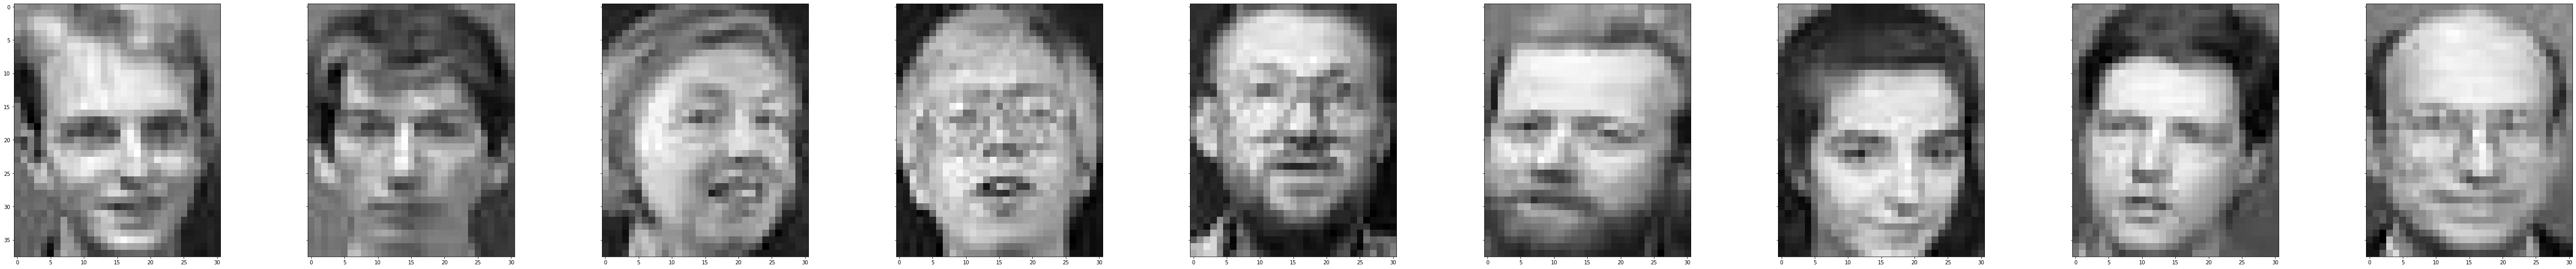

In [5]:
X_train, y_train, X_test, y_test = loaddata('../data/faces.mat')

def plotfaces(X, xdim=38, ydim=31):
    n, d = X.shape
    f, axes = plt.subplots(1, n, sharey=True)
    f.set_figwidth(10 * n)
    f.set_figheight(n)
    
    if n > 1:
        for i in range(n):
            axes[i].imshow(X[i,:].reshape(ydim, xdim).T, cmap=plt.cm.binary_r)
    else:
        axes.imshow(X[0,:].reshape(ydim, xdim).T, cmap=plt.cm.binary_r)

plt.figure(figsize=(11,8))
plotfaces(X_train[:9,:])

<h2>Implement k-NN for Facial Recognition</h2>

<p>The following four project parts will step through implementing each function necessary to build the facial recognition system.</p>

<h3>Part 1: Implement <b><code>findknn</code></b></h3>

<p>Implement the function <b><code>findknn</code></b>, which should find the $k$ nearest neighbors of a set of vectors within a given training data set. The call of:</p>

<pre>[I,D] = findknn(X_train, X_test, k);</pre> 

<p>should result in two matrices $I$ and $D$, both of dimensions $k\times n$, where $n$ is the number of input vectors in <code>Xtest</code>. The matrix $I(i,j)$ is the index of the $i^{th}$ nearest neighbor of the vector $Xtest(j,:)$.</p>

<p>So, for example, if we set <code>i=I(1,3)</code>, then <code>Xtrain(i,:)</code> is the first nearest neighbor of vector <code>Xtest(3,:)</code>. The second matrix $D$ returns the corresponding distances. So $D(i,j)$ is the distance of $Xtest(j,:)$ to its $i^{th}$ nearest neighbor.</p>

In [6]:
def findknn(X_train, X_test, k):
    """
    function [indices, dists] = findknn(X_train, X_test, k);
    
    This function finds the k nearest neighbors of X_test in X_train.
    
    Inputs:
    ------
    X_train : nxd input matrix with n row-vectors of dimensionality d
    X_test  : mxd input matrix with m row-vectors of dimensionality d
    k       : number of nearest neighbors to be found
    
    Outputs:
    -------
    indices : kxm matrix, where indices(i,j) is the i^th nearest neighbor of X_test(j,:)
    dists   : Euclidean distances to the respective nearest neighbors
    """
    dists = l2distance(X_train, X_test)
    indices = np.argsort(dists, axis=0)
    dists = np.sort(dists, axis=0)
    
    return indices[:k,:], dists[:k,:]

<h3>Part 2: Implement <b><code>accuracy</code></b></h3>

<p>The function <b><code>accuracy</code></b> should compute the accuracy of a classifier. The call of:</p>

<pre>result = accuracy(truth, preds);</pre>

<p>should output the <b>accuracy</b> in variable <code>result</code>. The input variables <code>truth</code> and <code>preds</code> should contain vectors of true and predicted labels respectively.</p>

<p>For example, the call:</p>

<pre>>> accuracy([1 2 1 2],[1 2 1 1])</pre>

<p>should return an accuracy of 0.75. Here, the true labels are 1,2,1,2 and the predicted labels are 1,2,1,1. So the first three examples are classified correctly, and the last one is wrong --- 75% accuracy.</p>

In [7]:
def accuracy(truth, preds):
    """
    function output = accuracy(truth, preds)
    
    This function analyzes the accuracy of a prediction against the ground truth.
    
    Inputs:
    ------
    truth : n-dimensional vector of true class labels
    preds : n-dimensional vector of predictions
    
    Outputs:
    -------
    accuracy : scalar (percent of predictions that are correct)
    """
    truth = truth.flatten()
    preds = preds.flatten()
    accuracy = np.mean(truth == preds)
    
    return accuracy

<h3>Part 3: Implement <b><code>knnclassifier</code></b></h3>

<p>Implement the function <b><code>knnclassifier</code></b>, which should perform $k$ nearest neighbor classification on a given test data set. The call:</p>

<pre>preds = knnclassifier(X_train, y_train, X_test, k)</pre>

<p>should output the predictions for the data in <code>Xtest</code> i.e. <code>preds[i]</code> will contain the prediction for <code>Xtest[i,:]</code>.</p>

In [8]:
def knnclassifier(X_train, y_train, X_test, k):
    """
    function preds = knnclassifier(X_train, y_train, X_test, k);
    
    This function performs k-nn classification.
    
    Inputs:
    ------
    X_train : nxd input matrix with n row-vectors of dimensionality d
    y_train : input vector of X_train labels
    X_test  : mxd input matrix with m row-vectors of dimensionality d
    k       : number of nearest neighbors to be found
    
    Outputs:
    -------
    preds : predicted labels, ie preds(i) is the predicted label of X_test(i,:)
    """
    # fix array shapes
    y_train = y_train.flatten()
    
    # get nearest neighbors
    indices, dists = findknn(X_train, X_test, k)
    predictions, freq = mode(y_train[indices])
    
    return predictions[0]

<p>You can compute the actual classification error on the test set by calling</p>

<pre>>> accuracy(y_test, knnclassifier(X_train, y_train, X_test, 3))</pre>

<h3><b>Part 4: Calculate Accuracy</b></h3>

<p>The following script runs the $k$-nearest neighbor classifier over the faces data set. The faces data set has $40$ classes.</p>

In [9]:
print('Face Recognition: (1-nn)')

X_train, y_train, X_test, y_test = loaddata('../data/faces.mat')
t0 = time.time()
preds = knnclassifier(X_train, y_train, X_test, 1)
result = accuracy(y_test, preds)
t1 = time.time()

print('You obtained %.2f%% classification acccuracy in %.4f seconds\n' % (100 * result, t1 - t0))

Face Recognition: (1-nn)
You obtained 95.83% classification acccuracy in 0.0309 seconds

